# Introduction to Clustering with Customer Segmentation

What is clustering? Clustering is an unsupervised machine learning algorithm that only takes input, X, but not labelled output, y. Clustering algorithms partition datas into distinct subgroups/clusters. For example, given a dataset of mall customers with features like 'Age', 'Income', 'Spending Score', we feed the clustering algorithm with the dataset and it will create a number of clusters based on the characteristics of the data and the specific algorithm with its parameters we use for clustering. In clustering, our main goal is to break down a big dataset into a few distinct subgroups so that we can use the subgroups to understand our data more easily or in a technical term, exploratory data analysis. However, since we do not have any labelled data for clustering algorithm, it is often diffucult to measure the performance of our model since we cannot compare the clusters with some ground truth answer to measure the performance. So, domain knowledge of the dataset is very important to interpret if we have reasonable and useful clusters.

There are many clustering algorithms and we will discuss three of the most popular ones which are:
 - K-Means clustering
 - Hierachical clustering(Agglomerative approach)
 - DBSCAN(Density Based Spatial Clustering of Application with Noise) 

Goals of this notebook:
 - Provide intuitive tutorial of clustering technique
 - Applying clustering techniques and evaluate their performance on certain dataset
 - Discuss the pros and cons of each of the three techniques

## Understanding the data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import mglearn

df = pd.read_csv("mall_customers.csv")

#### 1. Looking at the first 5 rows of the data

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### 2. Renaming the columns so that it is easier to use later.

In [4]:
df.columns = ['customer_ID','gender','age','annual_income','spending_score']
df.head()

,customer_ID,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### 3. The data contains 200 rows and 5 columns.

In [5]:
df.shape

(200, 5)

#### 4. There is no duplicated rows.

In [6]:
df.duplicated().any()

False

#### 5. There is no missing values in the dataset. 

In [7]:
df.isnull().any()

customer_ID       False
gender            False
age               False
annual_income     False
spending_score    False
dtype: bool

#### 6. Changing the index of the dataset to 'customer_ID' since 'customer_ID' will not provide us any insightful information for that customer except for indexing the specific customer.

In [11]:
df = df.set_index(['customer_ID'])
df.head()

KeyError: "None of ['customer_ID'] are in the columns"

## Exploratory Data Analysis and Data Visualization

#### Inspect the relationship between each feature using a pairplot.

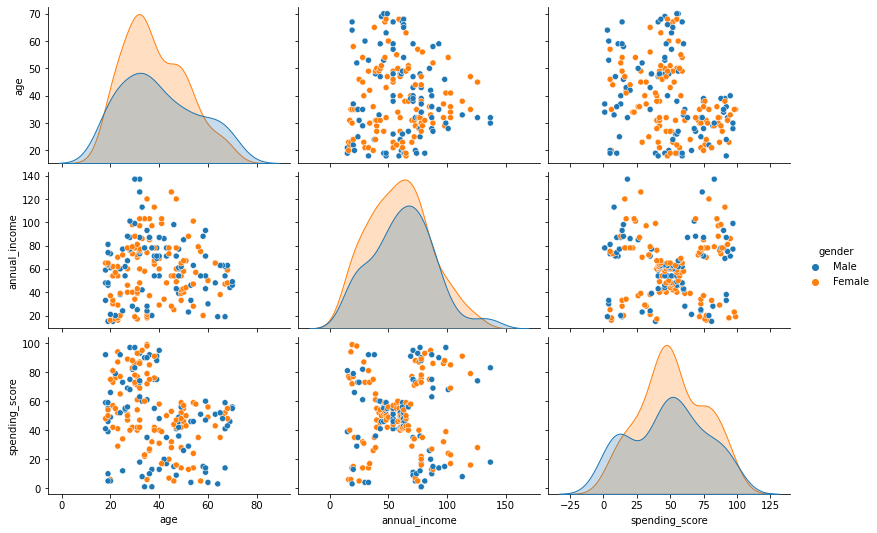

In [14]:
sns.pairplot(df, hue='gender',aspect = 1.5)
plt.show()

- From the plot above, we can see that there is no obvious difference between Male and Female in all plots.
- As a result, we will drop the 'gender' column since most of the distance-based algorithm cannot process categorical/binary data properly to provide meaningful results. To cluster a dataset with both numerical and categorical data, you can consider and look for K-Modes clustering which is out-of-scope of this discussion.

## Clustering

#### Dropping the 'gender' column for our three distance-based clustering techniques.

In [19]:
X = df.drop(['gender'], axis=1)
X.head()

### 1. K-Means Clustering

K-Means clustering is one of the most simple and commonly used clustering algorithm. It works as follows:
 1. Randomly assign k = n_clusters of cluster centre(centroids).
 2. Assign each datapoint to the closest centroids.
 3. Calculate the mean of all the points in each cluster and reassign the centroid of each cluster as the mean.
 4. Reassign each datapoint to the closest centroid based on Euclidean distance.
 5. Repeat Step 3 and Step 4 until the total sum of the within-cluster variation over the three clusters is the minimum.

#### An illustration showing the steps of K-Means clustering, taken from 'Introduction to Machine Learning with Python' book.

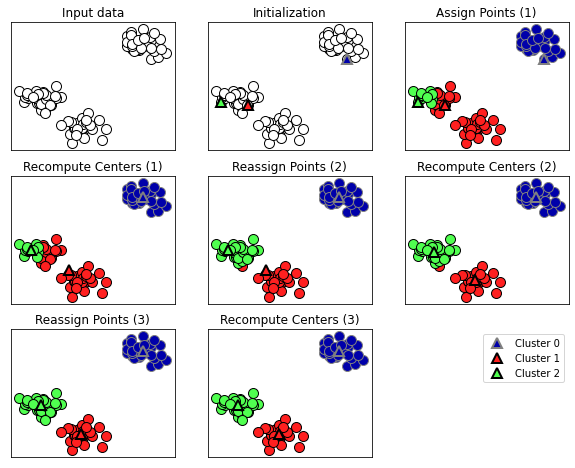

In [25]:
mglearn.plots.plot_kmeans_algorithm()

#### Implementation for Customer Data

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
clusters = []
ss = []

#Calculate all the sum of within-cluster variance for n_clusters from 2 to 14

for i in range(2,15):
    km = KMeans(n_clusters = i)
    km.fit(X)
    clusters.append(km.inertia_)
    ss.append(silhouette_score(X, km.labels_, metric='euclidean'))


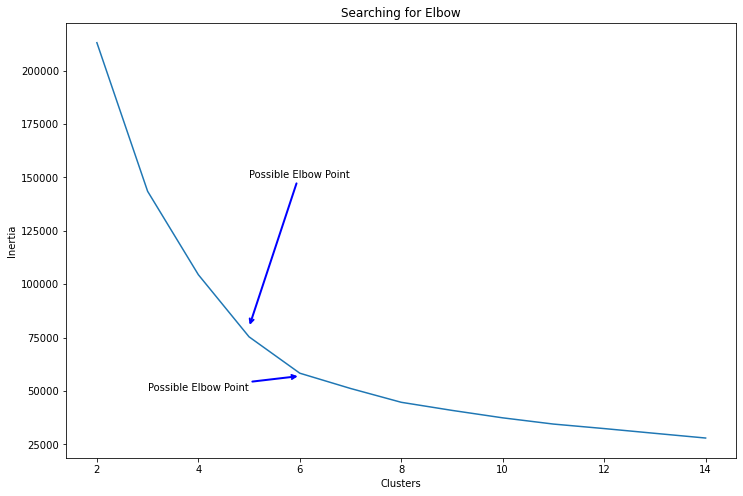

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(2, 15)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(6, 57000), xytext=(3, 50000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

- __The plot above is called an elbow method/plot. It illustrates the inertia(sum of squared distances of each data point to their closest centroid / sum of within-cluster variance) against n_clusters(number of clusters). Practically, we will not choose the n_clusters for the minimum inertia and instead, we will choose the so-called elbow point, as illustrated above, since it explains the majority of the inertia(variance). However, sometimes by just visually inspecting the elbow points are not enough to tell which n_clusters is the optimal choice like the elbow plot illustrated above. One way to tackle this problem is to pick both elbow points, use them for clustering, evaluate the results based on our domain knowledge and finally choose the best n_clusters. Increasing the number of clusters from that elbow point does not provide extra much information and it might produce an undesired results. As a rule of thumb, we choose the n_clusters based on the elbow point.__

- __Another way is to use another metric, Silhouette score, to validate our choice of n_clusters.The Silhouette score measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of Silhouette score is between -1 and +1. The score closer to +1 indicates that the data points are in the right cluster. If many points have negative Silhouette score, it may indicate that we either have created too many clusters or too less clusters. Silhouette score also utilize Euclidean distance to compute its score. In contrast to inertia, Silhouette score reaches its global maximum at the optimal K value.__ 

Text(0, 0.5, 'Silhouette Score')

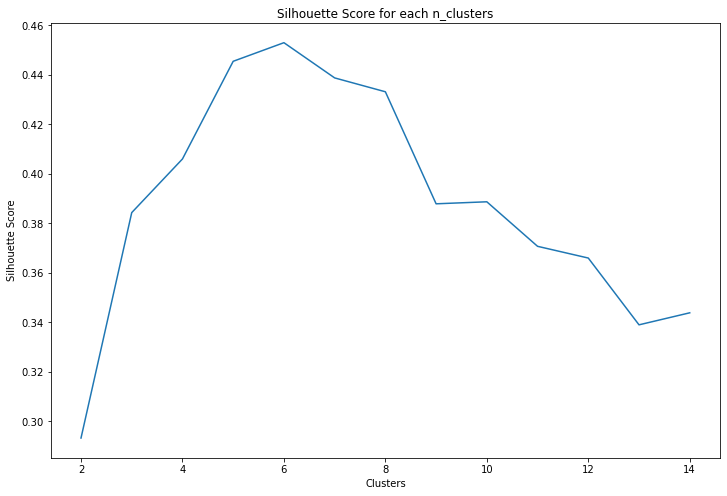

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(2, 15)), y=ss, ax=ax)
ax.set_title('Silhouette Score for each n_clusters')
ax.set_xlabel('Clusters')
ax.set_ylabel('Silhouette Score')

- __As we can see from the plot above, K=6 is has a higher Silhouette score than K=5 but both are very close, hence, we can inspect both possibilities and finally choose the one which is more sensible gauged by our domain knowledge.__
- __The Elbow method is more like a decision rule rather than a metric while the Silhouette score is a metric for clustering validation. Hence, they are not alternative to each other to find optimal K but rather, they can be used together to find a value of K with more confident.__

/Users/oscarliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



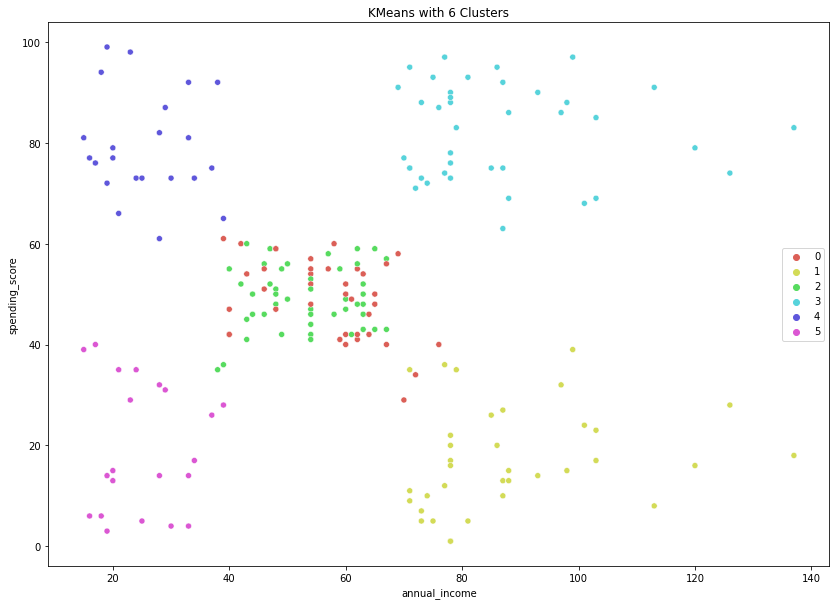

In [49]:
km6 = KMeans(n_clusters=6).fit(X)

X['Labels'] = km6.labels_
plt.figure(figsize=(14, 10))
sns.scatterplot(X['annual_income'], X['spending_score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 6))
plt.title('KMeans with 6 Clusters')
plt.legend(loc='center right')
plt.show()

- __As we can see from the scatterplot above, there are 4 obvious clusters and two mixed clusters in the middle(green+red)__

/Users/oscarliu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



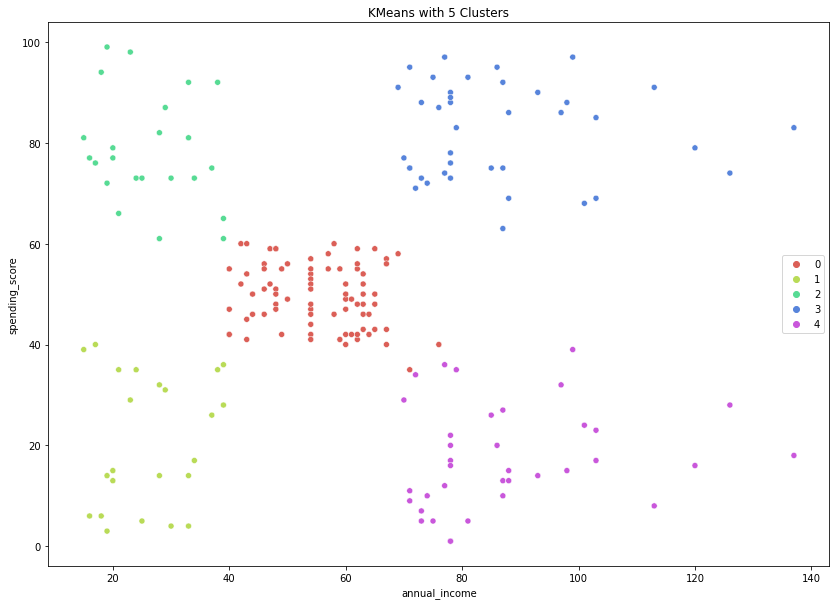

In [51]:
km5 = KMeans(n_clusters=5).fit(X)

X['Labels'] = km5.labels_
plt.figure(figsize=(14, 10))
sns.scatterplot(X['annual_income'], X['spending_score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 5))
plt.title('KMeans with 5 Clusters')
plt.legend(loc='center right')
plt.show()

- __As compare to the 6 clusters plot, 5 clusters can better differentiate each of the subgroups. The five groups are:__
 1. Low income with low spending score(Cluster 1)
 2. Low income with high spending score(Cluster 2)
 3. Medium income with medium spending score(Cluster 0)
 4. High income with low spending score(Cluster 4)
 5. High income with high spending score(Cluster 3)
 

- __For the 6 clusters plot, there are two clusters in the middle income with medium spending score which we cannot tell the differences between the two clusters in the middle. Hence, with our domain knowledge, we choose K = 5 which is better representing our data.__

- __We can also conclude that K-Means is very good at customer segmentation, more specifically on data clusters that have a spherical distribution. This is because K-Means utilize a centroid and the centroid measure each data point's distance from the centroid to the point using Euclidean distance in all direction from the centroid.__

- __As a result, K-Means tend to perform very badly when the data clusters do not have spherical shape.__

Text(0, 0.5, 'Feature 1')

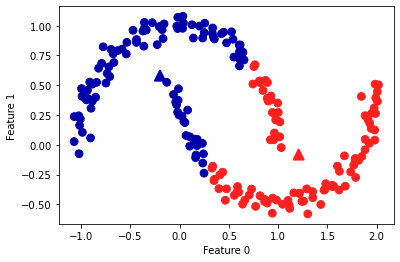

In [52]:
from sklearn.datasets import make_moons
x, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)
y_pred = kmeans.predict(x)
  

plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap=mglearn.cm2, s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

- __We can clearly see KMeans fail to cluster correctly the above two half-moon shaped datas because their distribution of data is not spherical. We can see that the model cluster all the datapoint that is within a certain distance from the centroid(blue and red triangle) as the same cluster. So, we should inspect our data and consider properly when we choose our clustering algorithm.__

### 2. Hierachical clustering(Agglomerative approach)